In [1]:
# # Path to h5ad dataset
# dataset_path = '/work/vanaja_lab/griffin/projects/cshmm/results/pancreas_dev.h5ad'

# # Load and prepare AnnData
# if os.path.exists(dataset_path):
#     print("File exists. Loading the dataset...")
#     adata = sc.read_h5ad(dataset_path)
#     print("Dataset loaded successfully!")
#     print("Dataset shape:", adata.shape)
# else:
#     raise FileNotFoundError(f"File not found at: {dataset_path}")

# adata.obs_names_make_unique()

# # Preprocessing steps
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)

# # Min-max scaling
# scaler = MinMaxScaler()
# adata.X = scaler.fit_transform(adata.X.toarray())

# # HVG selection
# sc.pp.highly_variable_genes(adata, n_top_genes=1000, flavor='seurat')
# adata = adata[:, adata.var['highly_variable']].copy()

# print(f"Dataset shape after selecting top 1000 HVGs: {adata.shape}")


In [2]:
# Dimensionality reduction and clustering
# sc.pp.pca(adata)
# sc.pp.neighbors(adata)
# sc.tl.umap(adata)
# sc.tl.leiden(adata, resolution=2, key_added="leiden")

# # Plot UMAP with clusters
# sc.pl.umap(adata, color="leiden", legend_loc="on data", title="UMAP - Leiden Clusters")

# # PAGA
# sc.tl.paga(adata, groups='leiden')
# sc.pl.paga(adata, color='leiden', title="PAGA Connectivity Graph")
# sc.pl.umap(adata, color=['leiden'], edges=True, title="UMAP with PAGA Connectivity")


In [3]:
#adata.write('data/mouse_panc_dev.h5ad')

In [4]:
import os
import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from models import TrajectoryGraph, initialize_trajectory


/work/vanaja_lab/griffin/miniconda3/envs/cellrank/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/work/vanaja_lab/griffin/miniconda3/envs/cellrank/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/work/vanaja_lab/griffin/miniconda3/envs/cellrank/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/work/vanaja_lab/griffin/miniconda3/envs/cellrank/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/work/vanaja_lab/griffin/miniconda3/envs/cellr

In [5]:
adata = sc.read('data/mouse_panc_dev.h5ad')

In [6]:
# Build the trajectory graph
traj_graph, cell_assignment = initialize_trajectory(
    adata=adata,
    random_state=41,
    debug=True
)


Trajectory graph nodes: ['leaf_0', 'split_1', 'leaf_2', 'leaf_3', 'leaf_4', 'split_5', 'root_split_6', 'leaf_7', 'leaf_8', 'split_9', 'leaf_10', 'split_11', 'split_12', 'split_13', 'int_14', 'split_15', 'leaf_16', 'leaf_17', 'RootNode_0_0']
Trajectory graph edges: [('split_1', 'split_9'), ('split_1', 'split_15'), ('split_5', 'leaf_7'), ('split_5', 'leaf_10'), ('root_split_6', 'split_1'), ('root_split_6', 'split_13'), ('split_9', 'leaf_3'), ('split_9', 'leaf_17'), ('split_11', 'split_12'), ('split_11', 'int_14'), ('split_12', 'leaf_2'), ('split_12', 'leaf_8'), ('split_13', 'split_5'), ('split_13', 'split_11'), ('int_14', 'leaf_4'), ('split_15', 'leaf_0'), ('split_15', 'leaf_16'), ('RootNode_0_0', 'root_split_6')]

Sample cell assignments:
                                 edge  latent_time
TAAGCGTAGGCCCGTT    (int_14, leaf_4)     0.773956
GACCAATAGTCGTCGT  (split_12, leaf_8)     0.438878
CGAGAAGCATGCTAGT    (int_14, leaf_4)     0.858598
ACGATGTAGGATTCCC    (int_14, leaf_4)     0.697368
G

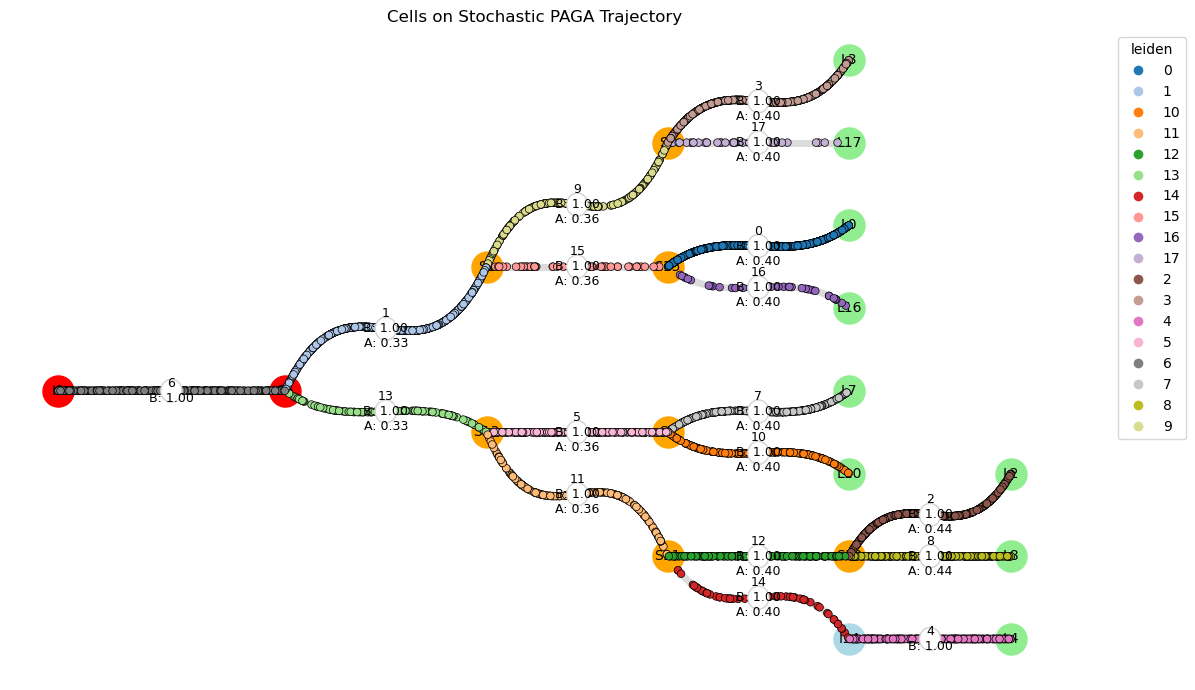

In [7]:
# Visualize trajectory graph with cells assigned
traj_graph.plot_cells_on_trajectory(
    cell_assignment=cell_assignment,
    color_key='leiden',
    curve_amount=0.8,
    node_size=500,
    cell_size=30,
    horizontal_thresh=0.01,
    edge_width=5,
    edge_color='lightgrey',
    title="Cells on Stochastic PAGA Trajectory",
    plot_transitions=True
)


In [8]:
# # === Imports ===

import torch
import numpy as np
from models.posterior import TreeVariationalPosterior
from models.belief import BeliefPropagator
from models.emission import pack_emission_params
from models.loss import compute_elbo
from utils.inference import initialize_beta_from_cell_assignment, find_path_index_for_edge

# # === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# === Prepare expression data ===
X = torch.tensor(
    adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X,
    dtype=torch.float32,
    device=device
)

# === Initialize trajectory graph ===
traj_graph, cell_assignment = initialize_trajectory(adata, debug=True)
traj_graph.edge_list = list(traj_graph.G_traj.edges())

all_nodes = set(traj_graph.node_to_index.keys())
emission_nodes = set(traj_graph.node_emission.keys())
missing = all_nodes - emission_nodes
print(f"\nAll nodes:      {sorted(all_nodes)}")
print(f"Emission nodes: {sorted(emission_nodes)}")
print(f"Missing nodes:  {sorted(missing)}")

# === Emission parameter initialization ===
edge_to_index, g_a, g_b, K, sigma2, pi, g = pack_emission_params(traj_graph, device=device)

# === Wrap emission parameters in nn.Parameter for autograd ===
g = torch.nn.Parameter(g)
K = torch.nn.Parameter(K)
log_sigma2 = torch.nn.Parameter(torch.log(sigma2))

# === Posterior setup ===
n_cells = X.shape[0]
posterior = TreeVariationalPosterior(traj_graph, n_cells=n_cells, device=device)
print("edge_logits requires_grad:", posterior.edge_logits.requires_grad)

# === Initialize beta from trajectory assignment (optional) ===
initialize_beta_from_cell_assignment(posterior, cell_assignment, edge_to_index, sharpness=0.1)

# === Belief propagator ===
belief_propagator = BeliefPropagator(traj_graph, posterior)

# === Diagnostics ===
print("g requires_grad:", g.requires_grad)
print("Initial alpha mean:", posterior.alpha.mean().item())
print("Initial beta mean:", posterior.beta.mean().item())

# === Group learnable emission parameters (if needed elsewhere) ===
emission_params = [g, K, log_sigma2]


Trajectory graph nodes: ['leaf_0', 'split_1', 'leaf_2', 'split_3', 'int_4', 'split_5', 'split_6', 'leaf_7', 'leaf_8', 'split_9', 'leaf_10', 'split_11', 'leaf_12', 'root_split_13', 'leaf_14', 'split_15', 'leaf_16', 'leaf_17', 'RootNode_0_0']
Trajectory graph edges: [('split_1', 'split_11'), ('split_1', 'split_15'), ('split_3', 'leaf_7'), ('split_3', 'leaf_17'), ('int_4', 'leaf_2'), ('split_5', 'int_4'), ('split_5', 'split_9'), ('split_6', 'split_3'), ('split_6', 'split_5'), ('split_9', 'leaf_8'), ('split_9', 'leaf_16'), ('split_11', 'leaf_12'), ('split_11', 'leaf_14'), ('root_split_13', 'split_1'), ('root_split_13', 'split_6'), ('split_15', 'leaf_0'), ('split_15', 'leaf_10'), ('RootNode_0_0', 'root_split_13')]

Sample cell assignments:
                                edge  latent_time
TAAGCGTAGGCCCGTT   (split_5, int_4)     0.773956
GACCAATAGTCGTCGT  (split_9, leaf_8)     0.438878
CGAGAAGCATGCTAGT   (split_5, int_4)     0.858598
ACGATGTAGGATTCCC   (split_5, int_4)     0.697368
GCAGTTAAG

In [10]:
def test_branch_logits_grad_flow(posterior):
    print("\n=== TEST: branch_logits Gradient Flow ===")

    posterior.branch_logits.data.uniform_(-0.1, 0.1)
    posterior.branch_logits.grad = None

    B = posterior.compute_branch_probs()
    print("B.sum():", B.sum().item())

    # Force a scalar from B that depends on all branch_logits
    scalar = (B * torch.arange(1, len(B)+1, device=B.device)).sum()
    scalar.backward()

    print("branch_logits.grad:")
    print(posterior.branch_logits.grad)
    print("branch_logits.grad norm:", posterior.branch_logits.grad.norm().item())
    print("=========================================")


In [11]:
test_branch_logits_grad_flow(posterior)



=== TEST: branch_logits Gradient Flow ===
B.sum(): 10.0
branch_logits.grad:
tensor([-0.2495,  0.2495, -0.2499,  0.2499,  0.0000, -0.2497,  0.2497, -0.2500,
         0.2500, -0.2498,  0.2498, -0.2499,  0.2499, -0.2498,  0.2498, -0.2493,
         0.2493,  0.0000], device='cuda:0')
branch_logits.grad norm: 0.998903214931488


# Test Standard Full Code

In [12]:
# # === Run Variational Model ===
# for epoch in range(num_epochs):
#     optimizer.zero_grad()

#     loss, metrics = compute_elbo(
#         X, traj_graph, posterior, edge_to_index,
#         g_a, g_b, K, log_sigma2.exp(),
#         pi=pi,
#         belief_propagator=belief_propagator,
#         n_samples=n_samples,
#         kl_weight=kl_weight,
#         kl_p_weight=kl_p_weight,
#         t_cont_weight=t_cont_weight
#     )

#     loss.backward()
#     print_grad_stats()
#     log_epoch(epoch, loss, metrics)
#     optimizer.step()


In [13]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [14]:
print("branch_logits requires_grad:", posterior.branch_logits.requires_grad)


branch_logits requires_grad: True


In [ ]:
import torch
from models.loss import compute_elbo_batch
from utils.inference import batch_indices

def print_grad_status(name, param):
    if not param.requires_grad:
        print(f"🚫 {name}: requires_grad=False")
    elif param.grad is None:
        print(f"❌ {name}.grad is None")
    elif param.grad.norm().item() < 1e-10:
        print(f"⚠️ {name}.grad norm is ~0.0")
    else:
        print(f"✅ {name}.grad norm = {param.grad.norm().item():.2e}")

# === Logging containers ===
elbo_log, nll_log, kl_t_log, kl_p_log = [], [], [], []
t_cont_log, transition_log, l1_log, grad_log = [], [], [], []

# === Config ===
batch_size = 512
num_epochs = 500
n_samples = 3
kl_weight = 1.0
kl_p_weight = 1e4
t_cont_weight = 1.0
transition_weight = 1.0
l1_weight = 1.0
entropy_weight = 100
lr = 1e-2

# === Phase toggling ===
phase = "emission"
max_phase_epochs = 10
patience = 5
tol = 1e-3
best_loss = torch.tensor(float("inf"), device=X.device)
epochs_since_improvement = 0
phase_epoch = 0

# === Training loop ===
for epoch in range(num_epochs):
    # === Phase-specific parameter control ===
    if phase == "emission":
        posterior.freeze()
        for p in [g, K, log_sigma2]:
            p.requires_grad_(True)
        posterior.branch_logits.requires_grad_(True)
    else:
        posterior.unfreeze()
        for p in [g, K, log_sigma2]:
            p.requires_grad_(False)

    # === Optimizer setup ===
    trainable_params = list(p for p in posterior.parameters() if p.requires_grad) + \
                       [p for p in [g, K, log_sigma2] if p.requires_grad]
    optimizer = torch.optim.Adam(trainable_params, lr=lr)

    total_loss = torch.tensor(0.0, device=X.device)
    total_batches = 0
    epoch_metrics = {k: 0.0 for k in ["nll", "kl_t", "kl_p", "t_cont", "transition", "l1", "emission_cont", "entropy"]}

    for batch in batch_indices(X.shape[0], batch_size):
        X_batch = X[batch]
        optimizer.zero_grad()

        loss, metrics = compute_elbo_batch(
            X_batch, batch, traj_graph, posterior, edge_to_index,
            g, K, log_sigma2.exp(),
            belief_propagator=belief_propagator,
            n_samples=n_samples,
            kl_weight=kl_weight,
            kl_p_weight=kl_p_weight,
            t_cont_weight=t_cont_weight,
            transition_weight=transition_weight,
            l1_weight=l1_weight,
            pi=pi
        )
        with torch.autograd.set_detect_anomaly(True):
            loss.backward()

        # print("\n--- GRADIENT STATUS (before step) ---")
        # print_grad_status("posterior.edge_logits", posterior.edge_logits)
        print_grad_status("posterior.branch_logits", posterior.branch_logits)
        # print_grad_status("posterior.alpha", posterior.alpha)
        # print_grad_status("posterior.beta", posterior.beta)
        # print_grad_status("g", g)
        # print_grad_status("K", K)
        # print_grad_status("log_sigma2", log_sigma2)

        optimizer.step()

        total_loss += loss
        for key in epoch_metrics:
            epoch_metrics[key] += metrics.get(key, 0.0)
        total_batches += 1

    for key in epoch_metrics:
        epoch_metrics[key] /= total_batches

    avg_loss = total_loss / total_batches
    elbo_log.append(avg_loss.item())
    nll_log.append(epoch_metrics["nll"])
    kl_t_log.append(epoch_metrics["kl_t"])
    kl_p_log.append(epoch_metrics["kl_p"])
    t_cont_log.append(epoch_metrics["t_cont"])
    transition_log.append(epoch_metrics["transition"])
    l1_log.append(epoch_metrics["l1"])
    grad_log.append({k: v.grad.norm().item() if v.grad is not None else 0.0
                     for k, v in zip(["edge_logits", "branch_logits", "alpha", "beta", "g", "K", "log_sigma2"],
                                     [posterior.edge_logits, posterior.branch_logits,
                                      posterior.alpha, posterior.beta,
                                      g, K, log_sigma2])})

    print(f"\n[Epoch {epoch}] | Phase: {phase}")
    print(f"  ELBO:         {avg_loss.item():.4e}")
    print(f"  NLL:          {epoch_metrics['nll']:.4e}")
    print(f"  KL(t):        {epoch_metrics['kl_t']:.4e}")
    print(f"  KL(p):        {epoch_metrics['kl_p']:.4e}")
    print(f"  t_cont:       {epoch_metrics['t_cont']:.4e}")
    print(f"  Transition:   {epoch_metrics['transition']:.4e}")
    print(f"  L1:           {epoch_metrics['l1']:.4e}")
    print(f"  Emission MSE: {epoch_metrics['emission_cont']:.4e}")
    print(f"  Entropy:      {epoch_metrics['entropy']:.4e}")

    # === Phase switching ===
    if avg_loss < best_loss - tol:
        best_loss = avg_loss
        epochs_since_improvement = 0
    else:
        epochs_since_improvement += 1

    phase_epoch += 1
    if epochs_since_improvement >= patience or phase_epoch >= max_phase_epochs:
        phase = "posterior" if phase == "emission" else "emission"
        best_loss = torch.tensor(float("inf"), device=X.device)
        epochs_since_improvement = 0
        phase_epoch = 0
        print(f"--- Switching to {phase} phase ---")


✅ posterior.branch_logits.grad norm = 6.61e-02
✅ posterior.branch_logits.grad norm = 4.93e-02
✅ posterior.branch_logits.grad norm = 3.37e-02
✅ posterior.branch_logits.grad norm = 2.19e-02
✅ posterior.branch_logits.grad norm = 1.64e-02
✅ posterior.branch_logits.grad norm = 1.72e-02
✅ posterior.branch_logits.grad norm = 2.06e-02
✅ posterior.branch_logits.grad norm = 2.37e-02
✅ posterior.branch_logits.grad norm = 2.54e-02
✅ posterior.branch_logits.grad norm = 2.56e-02
✅ posterior.branch_logits.grad norm = 2.45e-02

[Epoch 0] | Phase: emission
  ELBO:         4.7144e+05
  NLL:          4.7141e+05
  KL(t):        9.5126e-02
  KL(p):        -2.0782e-09
  t_cont:       3.3533e-01
  Transition:   -1.7453e+01
  L1:           2.2583e+01
  Emission MSE: 2.0241e-03
  Entropy:      5.5441e+00
✅ posterior.branch_logits.grad norm = 2.24e-02
✅ posterior.branch_logits.grad norm = 1.42e-02
✅ posterior.branch_logits.grad norm = 8.41e-03
✅ posterior.branch_logits.grad norm = 9.60e-03
✅ posterior.branch_lo

In [25]:
# from models.loss import compute_elbo_batch
# from utils.inference import batch_indices

# batch_size = 512
# num_epochs = 100
# n_samples = 3
# freeze_epochs = 5
# # Training weights
# kl_weight = 1.0
# kl_p_weight = 1e4
# t_cont_weight = 1.0

# elbo_log = []
# nll_log = []
# kl_t_log = []
# kl_p_log = []
# t_cont_log = []
# transition_log = []
# l1_log = []
# grad_log = []

# # Freeze emission parameters initially
# emission_params = [g, K, log_sigma2]
# for p in emission_params:
#     p.requires_grad_(False)

# optimizer = torch.optim.Adam(
#     [posterior.alpha, posterior.beta, posterior.edge_logits] + emission_params,
#     lr=1e-2
# )

# for epoch in range(num_epochs):
#     total_loss = 0.0
#     total_batches = 0
#     epoch_metrics = {
#         "nll": 0.0,
#         "kl_t": 0.0,
#         "kl_p": 0.0,
#         "t_cont": 0.0,
#         "transition": 0.0,
#         "l1": 0.0
#     }

#     # === Unfreeze after warmup ===
#     if epoch == freeze_epochs:
#         for p in emission_params:
#             p.requires_grad_(True)

#     for batch in batch_indices(X.shape[0], batch_size):
#         assert batch.dtype == torch.long, f"batch dtype is {batch.dtype}, expected torch.long"
#         assert X.dim() == 2, f"X has shape {X.shape}, expected 2D tensor"

#         # print("batch shape:", batch.shape)
#         # print("batch dtype:", batch.dtype)
#         # print("min(batch):", batch.min().item())
#         # print("max(batch):", batch.max().item())
#         # print("X.shape[0]:", X.shape[0])

#         torch.cuda.synchronize()
#         X_batch = X[batch]
#         optimizer.zero_grad()

#         # print("posterior edge list:")
#         # for i, edge in enumerate(posterior.edge_list):
#         #     print(f"{i}: {edge}")
        
#         # print("traj_graph.edge_list:")
#         # for i, edge in enumerate(traj_graph.edge_list):
#         #     print(f"{i}: {edge}")

#         loss, metrics = compute_elbo_batch(
#             X_batch, batch,
#             traj_graph, posterior, edge_to_index,
#             g, K, log_sigma2.exp(),
#             belief_propagator=belief_propagator,
#             n_samples=n_samples,
#             kl_weight=kl_weight,
#             kl_p_weight=kl_p_weight,
#             t_cont_weight=t_cont_weight,
#             transition_weight=1.0,  # adjustable
#             pi=pi
#         )

#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()
#         for key in epoch_metrics:
#             epoch_metrics[key] += metrics.get(key, 0.0)
#         total_batches += 1

#     # Normalize per batch
#     for key in epoch_metrics:
#         epoch_metrics[key] /= total_batches

#     # === Log gradient norms ===
#     grad_norms = {
#         "alpha": posterior.alpha.grad.norm().item() if posterior.alpha.grad is not None else 0.0,
#         "beta": posterior.beta.grad.norm().item() if posterior.beta.grad is not None else 0.0,
#         "edge_logits": posterior.edge_logits.grad.norm().item() if posterior.edge_logits.grad is not None else 0.0,
#         "g": g.grad.norm().item() if g.grad is not None else 0.0,
#         "K": K.grad.norm().item() if K.grad is not None else 0.0,
#         "log_sigma2": log_sigma2.grad.norm().item() if log_sigma2.grad is not None else 0.0,
#     }

#     # Store logs
#     elbo_log.append(total_loss / total_batches)
#     nll_log.append(epoch_metrics["nll"])
#     kl_t_log.append(epoch_metrics["kl_t"])
#     kl_p_log.append(epoch_metrics["kl_p"])
#     t_cont_log.append(epoch_metrics["t_cont"])
#     transition_log.append(epoch_metrics["transition"])
#     l1_log.append(epoch_metrics["l1"])
#     grad_log.append(grad_norms)

#     # === Print ===
#     print(f"\n[Epoch {epoch}]")
#     print(f"  ELBO:       {elbo_log[-1]:.4e}")
#     print(f"  NLL:        {epoch_metrics['nll']:.4e}")
#     print(f"  KL(t):      {epoch_metrics['kl_t']:.4e}")
#     print(f"  KL(p):      {epoch_metrics['kl_p']:.4e}")
#     print(f"  t_cont:     {epoch_metrics['t_cont']:.4e}")
#     print(f"  transition: {epoch_metrics['transition']:.4e}")
#     print(f"  L1:         {epoch_metrics['l1']:.4e}")
#     print("  Grad Norms:")
#     for k, v in grad_norms.items():
#         print(f"    {k}: {v:.2e}")



[Epoch 0]
  ELBO:       2.4935e+05
  NLL:        2.8862e+04
  KL(t):      2.2047e+05
  KL(p):      -1.9093e-09
  t_cont:     3.9220e-01
  transition: -1.6858e+01
  L1:         2.9333e+02
  Grad Norms:
    alpha: 4.88e+03
    beta: 1.33e+03
    edge_logits: 1.52e-05
    g: 0.00e+00
    K: 0.00e+00
    log_sigma2: 0.00e+00



KeyboardInterrupt



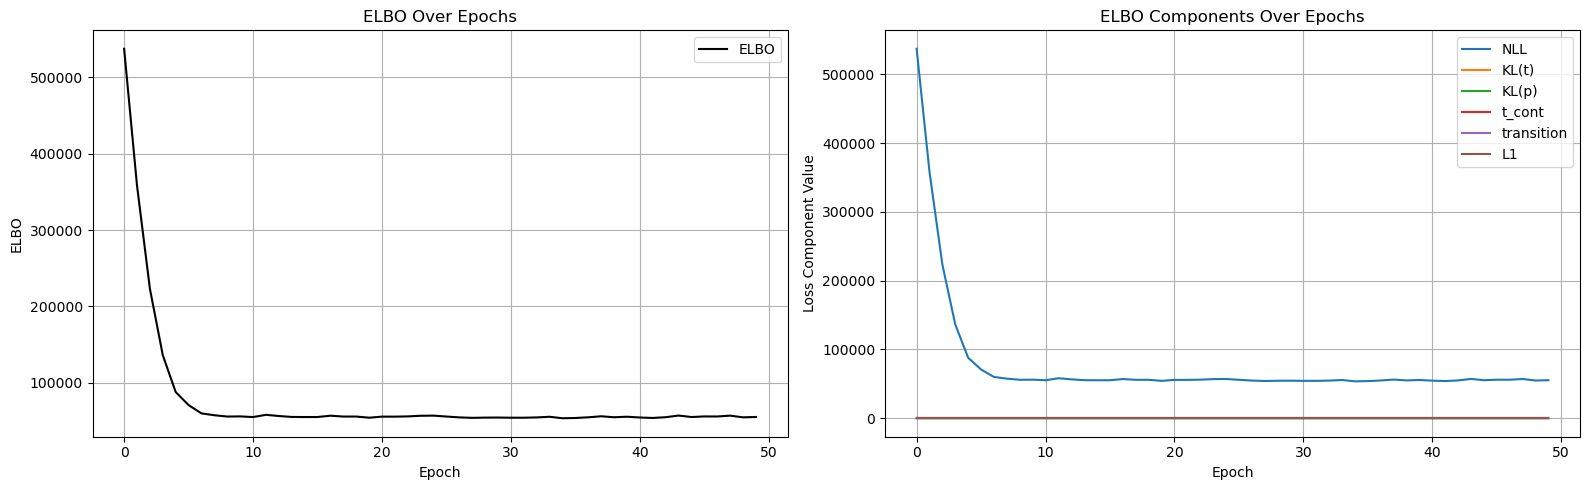

In [28]:
import matplotlib.pyplot as plt

epochs = range(len(elbo_log))

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# === ELBO plot ===
axes[0].plot(epochs, elbo_log, label="ELBO", color="black")
axes[0].set_title("ELBO Over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("ELBO")
axes[0].legend()
axes[0].grid(True)

# === Component losses ===
axes[1].plot(epochs, nll_log, label="NLL")
axes[1].plot(epochs, kl_t_log, label="KL(t)")
axes[1].plot(epochs, kl_p_log, label="KL(p)")
axes[1].plot(epochs, t_cont_log, label="t_cont")
axes[1].plot(epochs, transition_log, label="transition")
axes[1].plot(epochs, l1_log, label="L1")
axes[1].set_title("ELBO Components Over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss Component Value")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


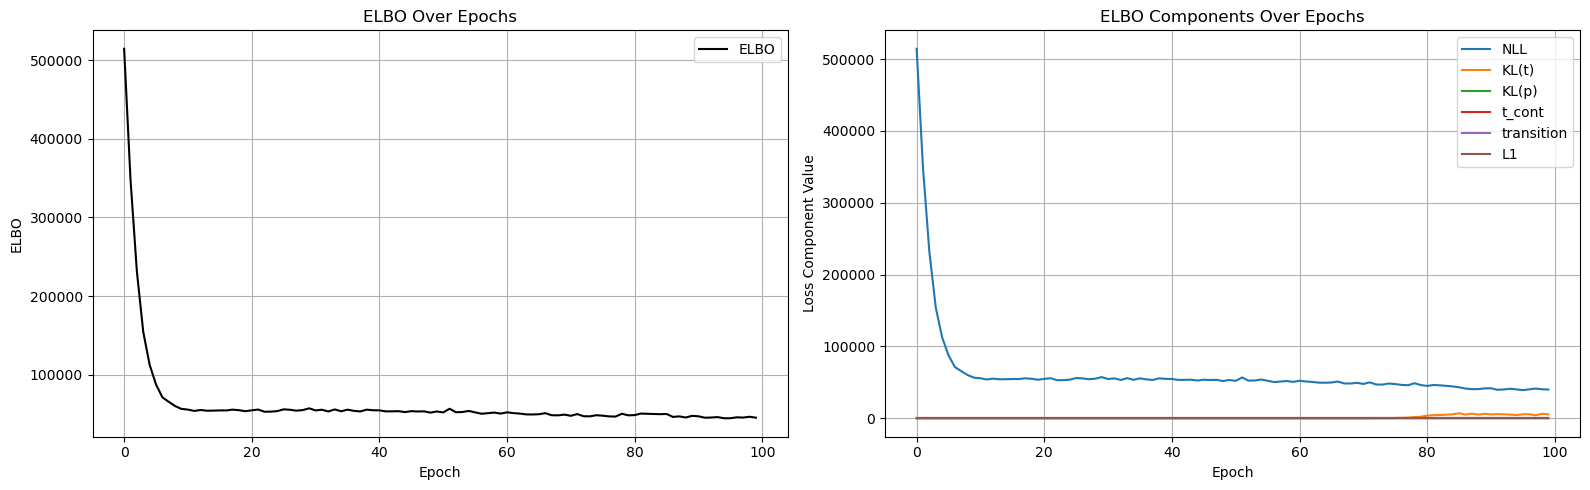

In [22]:
import matplotlib.pyplot as plt

epochs = range(len(elbo_log))

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# === ELBO plot ===
axes[0].plot(epochs, elbo_log, label="ELBO", color="black")
axes[0].set_title("ELBO Over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("ELBO")
axes[0].legend()
axes[0].grid(True)

# === Component losses ===
axes[1].plot(epochs, nll_log, label="NLL")
axes[1].plot(epochs, kl_t_log, label="KL(t)")
axes[1].plot(epochs, kl_p_log, label="KL(p)")
axes[1].plot(epochs, t_cont_log, label="t_cont")
axes[1].plot(epochs, transition_log, label="transition")
axes[1].plot(epochs, l1_log, label="L1")
axes[1].set_title("ELBO Components Over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss Component Value")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [21]:
index_to_edge = {v: k for k, v in edge_to_index.items()}
def extract_fitted_betas_by_argmax(posterior, index_to_edge):
    """
    Extract learned beta distribution parameters using the MAP edge assignment per cell.

    Args:
        posterior: Trained posterior object with `alpha` and `beta` of shape [cells x edges].
        index_to_edge: Dict mapping edge indices (int) to edge names.

    Returns:
        pd.DataFrame: Indexed by cell ID with columns 'edge', 'alpha', and 'beta'.
    """
    alpha = posterior.alpha.data.cpu().numpy()
    beta = posterior.beta.data.cpu().numpy()
    max_idx = (alpha + beta - 2).argmax(axis=1)  # MAP estimate of Beta distribution mean

    records = []
    for i, edge_idx in enumerate(max_idx):
        edge = index_to_edge[edge_idx]
        records.append({
        "cell_id": adata.obs.index[i],  # not just 'i'
        "edge": edge,
        "alpha": alpha[i, edge_idx],
        "beta": beta[i, edge_idx],
    })


    return pd.DataFrame(records).set_index("cell_id")
fitted_betas = extract_fitted_betas_by_argmax(posterior, index_to_edge)

In [50]:
adata

View of AnnData object with n_obs × n_vars = 0 × 1000
    obs: 'developmental_day', 'days_num', 'hours_num', 'source_tissue', 'leiden'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Sample_colors', 'developmental_day_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'ambiguous', 'counts', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [49]:
print("adata.obs.shape:", adata.obs.shape)
print("posterior alpha shape:", posterior.alpha.shape)


adata.obs.shape: (0, 5)
posterior alpha shape: torch.Size([5454, 18])


In [22]:
fitted_betas["edge"] = fitted_betas["edge"].apply(lambda x: tuple(x) if not isinstance(x, tuple) else x)
fitted_betas

,edge,alpha,beta
cell_id,,,
TAAGCGTAGGCCCGTT,"(split_17, leaf_4)",3.993999,5.905695
GACCAATAGTCGTCGT,"(split_0, split_8)",3.904192,6.028746
CGAGAAGCATGCTAGT,"(split_17, leaf_4)",2.838632,7.054723
ACGATGTAGGATTCCC,"(split_17, leaf_4)",5.247129,4.568557
GCAGTTAAGGTCATCT,"(split_17, leaf_4)",9.847487,-0.010192
...,...,...,...
GGAGCAAGTCTAGTGT,"(split_11, split_13)",5.985049,3.782763
TTTACTGTCAGTTCGG,"(RootNode_0_0, root_split_12)",8.566421,0.387073
GAAATGAGTCGGCACT,"(RootNode_0_0, root_split_12)",5.783636,3.941775


In [39]:
missing = fitted_betas.index.difference(adata.obs.index)
print(f"{len(missing)} missing cell IDs in adata")


5454 missing cell IDs in adata


In [36]:
missing_edges = [e for e in fitted_betas["edge"].unique() if e not in traj_graph.G_traj.edges
]
print("Missing edges:", missing_edges)


Missing edges: []


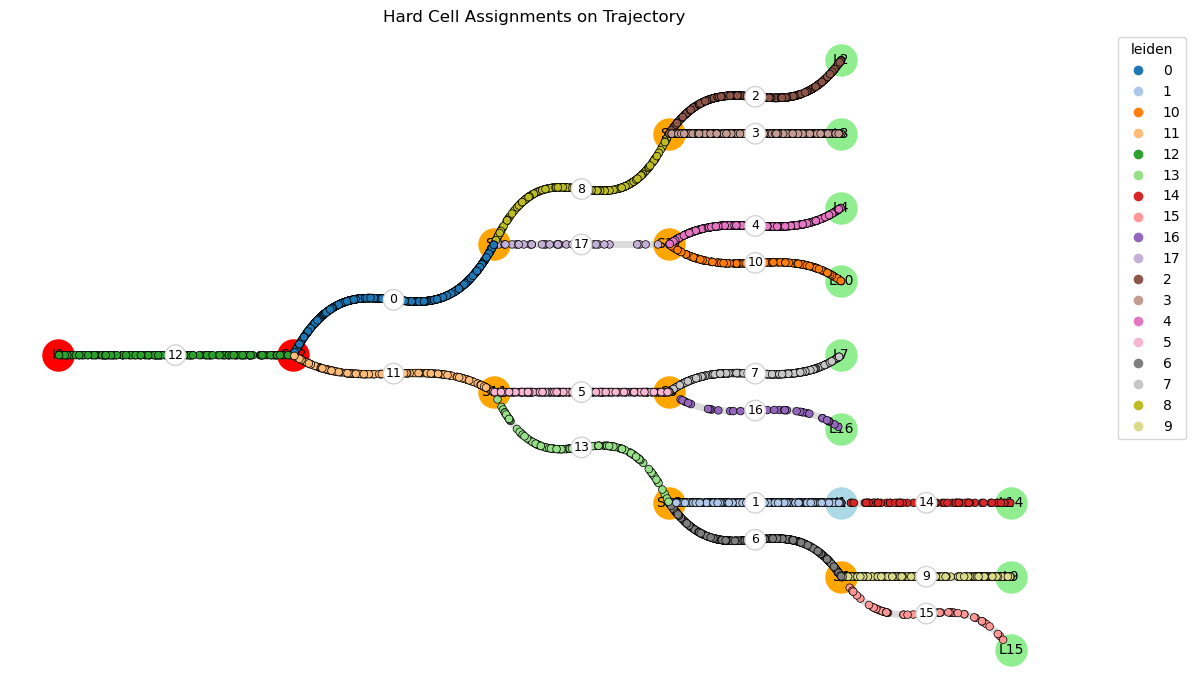

In [23]:
from viz.trajectory import plot_cells_on_trajectory

plot_cells_on_trajectory(
    traj_graph,
    cell_assignment,
    adata,
    color_key="leiden",  # or any other obs key
    curve_amount=0.8,
    title="Hard Cell Assignments on Trajectory"
)


/work/vanaja_lab/griffin/projects/viCSHMM/viz/trajectory.py:301: RuntimeWarning: overflow encountered in multiply
  widths = pdfs * (pdf_scale * seg_length) / max_vals
/work/vanaja_lab/griffin/projects/viCSHMM/viz/trajectory.py:305: RuntimeWarning: invalid value encountered in multiply
  offset = (width[:, None] / 2) * normals


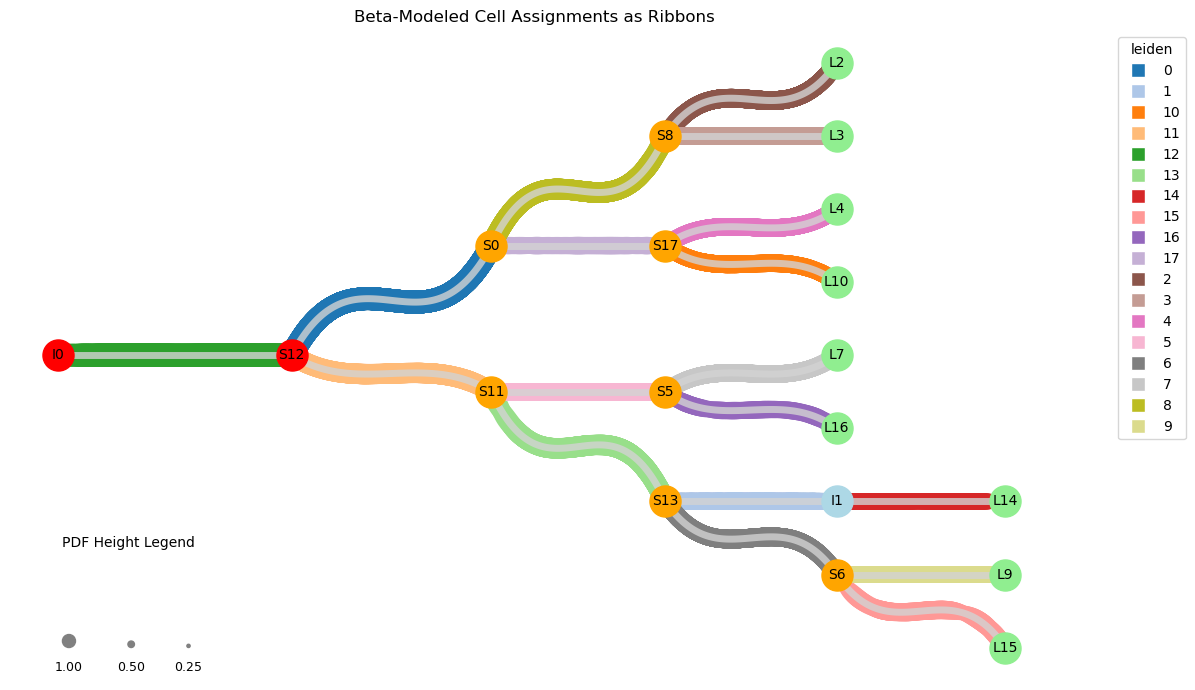

In [24]:
from viz.trajectory import plot_pdf_width_ribbons_on_trajectory

plot_pdf_width_ribbons_on_trajectory(
    traj_graph,
    fitted_betas,
    adata,
    color_key="leiden",
    pdf_scale=.1,  # adjust if too narrow/wide
    curve_amount=0.8,
    title="Beta-Modeled Cell Assignments as Ribbons"
)


In [12]:
# freeze_epochs = 10
# optimizer = torch.optim.Adam([
#     {'params': [posterior.alpha, posterior.beta, posterior.path_logits]},
#     {'params': [g_a, g_b, K, log_sigma2], 'lr': 1e-2}
# ], lr=1e-2)

# for epoch in range(num_epochs):
#     # Freeze emission parameters initially
#     if epoch < freeze_epochs:
#         for p in [g_a, g_b, K, log_sigma2]:
#             p.requires_grad_(False)
#     else:
#         for p in [g_a, g_b, K, log_sigma2]:
#             p.requires_grad_(True)

#     optimizer.zero_grad()
#     loss, metrics = compute_elbo(
#         X, traj_graph, posterior, edge_to_index,
#         g_a, g_b, K, log_sigma2.exp(),
#         pi=pi,
#         belief_propagator=belief_propagator,
#         n_samples=n_samples,
#         kl_weight=kl_weight,
#         kl_p_weight=kl_p_weight,
#         t_cont_weight=t_cont_weight,
#     )
#     loss.backward()
#     optimizer.step()

#     print(f"[Epoch {epoch}] Loss={loss.item():.2e}, NLL={metrics['nll']:.2e}, KL(t)={metrics['kl_t']:.3f}")


In [22]:
inference_params = [posterior.alpha, posterior.beta, posterior.path_logits]
generative_params = [g_a, g_b, K, log_sigma2]

optimizer_inf = torch.optim.Adam(inference_params, lr=1e-2)
optimizer_gen = torch.optim.Adam(generative_params, lr=1e-2)

n_inf_steps = 8
n_gen_steps = 3
batch_size = 512

elbo_log = []
metrics_log = []

for epoch in range(num_epochs):
    print(f"\n[Epoch {epoch}]")

    # === Inference Phase ===
    for _ in range(n_inf_steps):
        optimizer_inf.zero_grad()
        total_elbo = 0
        total_metrics = {
            "nll": 0.0,
            "kl_t": 0.0,
            "kl_p": 0.0,
            "t_cont": 0.0
        }
        n_batches = 0

        for batch in batch_indices(X.shape[0], batch_size):
            X_batch = X[batch]
            elbo, metrics = compute_elbo_batch(
                X_batch, batch,
                traj_graph, posterior, edge_to_index,
                g_a, g_b, K, log_sigma2.exp(),
                belief_propagator=belief_propagator,
                n_samples=n_samples,
                kl_weight=kl_weight,
                kl_p_weight=kl_p_weight,
                t_cont_weight=t_cont_weight,
                pi=pi
            )
            elbo.backward()
            total_elbo += elbo.item()
            for k in total_metrics:
                total_metrics[k] += metrics[k]
            n_batches += 1

        optimizer_inf.step()

        for k in total_metrics:
            total_metrics[k] /= n_batches

        print(f"Inference ELBO: {total_elbo:.2e}")
        print(f"  NLL:     {total_metrics['nll']:.3e}")
        print(f"  KL(t):   {total_metrics['kl_t']:.3e}")
        print(f"  KL(p):   {total_metrics['kl_p']:.3e}")
        print(f"  t_cont:  {total_metrics['t_cont']:.3e}")

        # Check gradients
        for p in inference_params:
            print(f"  Grad | {p.shape}: {p.grad.norm().item():.3e}")

        elbo_log.append(("inference", epoch, total_elbo))
        metrics_log.append(("inference", epoch, total_metrics.copy()))

    # === Generative Phase ===
    for _ in range(n_gen_steps):
        optimizer_gen.zero_grad()
        total_elbo = 0
        total_metrics = {
            "nll": 0.0,
            "kl_t": 0.0,
            "kl_p": 0.0,
            "t_cont": 0.0
        }
        n_batches = 0

        for batch in batch_indices(X.shape[0], batch_size):
            X_batch = X[batch]
            elbo, metrics = compute_elbo_batch(
                X_batch, batch,
                traj_graph, posterior, edge_to_index,
                g_a, g_b, K, log_sigma2.exp(),
                belief_propagator=belief_propagator,
                n_samples=n_samples,
                kl_weight=kl_weight,
                kl_p_weight=kl_p_weight,
                t_cont_weight=t_cont_weight,
                pi=pi
            )
            elbo.backward()
            total_elbo += elbo.item()
            for k in total_metrics:
                total_metrics[k] += metrics[k]
            n_batches += 1

        optimizer_gen.step()

        for k in total_metrics:
            total_metrics[k] /= n_batches

        print(f"Generative ELBO: {total_elbo:.2e}")
        print(f"  NLL:     {total_metrics['nll']:.3e}")
        print(f"  KL(t):   {total_metrics['kl_t']:.3e}")
        print(f"  KL(p):   {total_metrics['kl_p']:.3e}")
        print(f"  t_cont:  {total_metrics['t_cont']:.3e}")

        # Check gradients
        for p in generative_params:
            print(f"  Grad | {p.shape}: {p.grad.norm().item():.3e}")

        elbo_log.append(("generative", epoch, total_elbo))
        metrics_log.append(("generative", epoch, total_metrics.copy()))



[Epoch 0]
Inference ELBO: 6.06e+05
  NLL:     5.510e+04
  KL(t):   6.602e-01
  KL(p):   3.236e-02
  t_cont:  3.984e-01
  Grad | torch.Size([5454, 9]): 5.421e+03
  Grad | torch.Size([5454, 9]): 5.214e+03
  Grad | torch.Size([5454, 9]): 1.107e-02
Inference ELBO: 6.24e+05
  NLL:     5.676e+04
  KL(t):   6.625e-01
  KL(p):   3.129e-02
  t_cont:  3.923e-01
  Grad | torch.Size([5454, 9]): 5.667e+03
  Grad | torch.Size([5454, 9]): 5.241e+03
  Grad | torch.Size([5454, 9]): 1.082e-02
Inference ELBO: 6.06e+05
  NLL:     5.507e+04
  KL(t):   6.753e-01
  KL(p):   3.048e-02
  t_cont:  3.930e-01
  Grad | torch.Size([5454, 9]): 5.893e+03
  Grad | torch.Size([5454, 9]): 5.189e+03
  Grad | torch.Size([5454, 9]): 1.073e-02
Inference ELBO: 5.99e+05
  NLL:     5.446e+04
  KL(t):   6.731e-01
  KL(p):   2.948e-02
  t_cont:  4.002e-01
  Grad | torch.Size([5454, 9]): 5.762e+03
  Grad | torch.Size([5454, 9]): 5.317e+03
  Grad | torch.Size([5454, 9]): 1.050e-02
Inference ELBO: 5.94e+05
  NLL:     5.404e+04
  K


KeyboardInterrupt



# Test Plotting

In [55]:
from utils import make_beta_assignment_df

beta_assignments = make_beta_assignment_df(posterior, cell_assignment, sharpness=0.01)


TypeError: initialize_beta_from_cell_assignment() missing 1 required positional argument: 'edge_to_index'

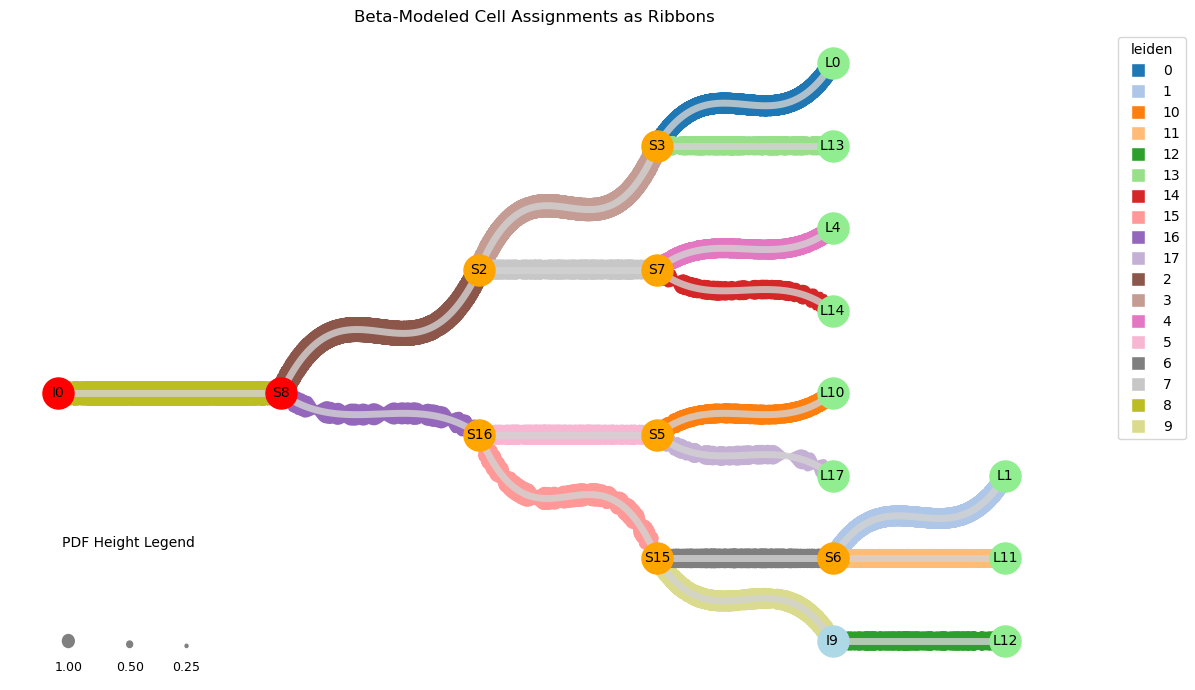

In [16]:
from viz.trajectory import plot_pdf_width_ribbons_on_trajectory

plot_pdf_width_ribbons_on_trajectory(
    traj_graph,
    beta_assignments,
    adata,
    color_key="leiden",
    pdf_scale=0.1,  # adjust if too narrow/wide
    curve_amount=0.8,
    title="Beta-Modeled Cell Assignments as Ribbons"
)


In [17]:
adata.var

,n_cells,highly_variable,means,dispersions,dispersions_norm
Lypla1,2576,True,0.250853,-0.930302,1.950977
Ncoa2,993,True,0.099955,-0.569126,1.877314
Gm10566,76,True,0.010847,-0.106430,1.912057
Imp4,3037,True,0.295466,-1.094584,1.782918
Fam168b,2119,True,0.204745,-0.815239,1.617195
...,...,...,...,...,...
Rps7-ps3,2274,True,0.221367,-0.861823,1.828743
Map3k15,346,True,0.038561,-0.390028,2.149240
Syap1,970,True,0.100843,-0.545244,1.989039
Ctps2,2537,True,0.264015,-0.860618,2.211714


In [18]:
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import networkx as nx
import pandas as pd

def plot_gene_dynamics_on_trajectory(
    G_traj, beta_assignments, adata, gene_name,
    resolution=100, curve_scale=1.0, blend_fraction=0.1,
    title="Gene Dynamics with Uncertainty"
):
    """
    Visualizes gene expression dynamics along trajectory edges while incorporating
    uncertainty from cell assignments. The tree structure is drawn first (nodes and
    straight edges). Over each edge, we compute for a set of t-values:
      - A weighted gene expression (which becomes the vertical offset from the base edge)
      - A weighted certainty (a proxy using each cell's beta PDF peak)
    
    The curve is drawn along the edge offset perpendicularly by the weighted expression
    (scaled by curve_scale). If the source node of an edge is a split, the first few points
    of the branch are blended with the parent's endpoint (source node position) using the 
    transition probability (attribute "A") from that edge.
    
    Args:
        G_traj: Trajectory graph (networkx.DiGraph or TrajectoryGraph object).
        beta_assignments (pd.DataFrame): Indexed by cell IDs with columns:
            'edge' (tuple of two node IDs), 'alpha', 'beta'.
        adata: AnnData-like object (for gene expression and cell IDs).
        gene_name (str): Gene to visualize (must be in adata.var_names).
        resolution (int): Number of t-values along each edge.
        curve_scale (float): Factor to scale the vertical offset of the curve.
        blend_fraction (float): Fraction of the curve (from t=0) to blend at split nodes.
        title (str): Plot title.
    """
    # If G_traj is a TrajectoryGraph, extract its underlying networkx graph.
    if hasattr(G_traj, 'G_traj'):
        G_traj = G_traj.G_traj

    # Compute node positions using graphviz layout.
    pos = nx.nx_agraph.graphviz_layout(G_traj, prog="dot", args="-Grankdir=LR")
    plt.figure(figsize=(12, 7))
    
    # Draw the tree structure: nodes and edges.
    for node, (x, y) in pos.items():
        plt.scatter(x, y, color='black', s=500, zorder=3)
        plt.text(x, y, node, fontsize=10, ha="center", va="center", zorder=4)
    for src, dst in G_traj.edges():
        if src not in pos or dst not in pos:
            continue
        P0, P1 = np.array(pos[src]), np.array(pos[dst])
        plt.plot([P0[0], P1[0]], [P0[1], P1[1]], color='lightgrey', lw=5, alpha=0.5, zorder=1)
    
    # Extract gene expression as a pandas Series (indexed by cell IDs).
    if gene_name in adata.var_names:
        gene_idx = adata.var_names.get_loc(gene_name)
        expr_array = (adata.X[:, gene_idx].toarray().ravel() 
                      if hasattr(adata.X, "toarray") 
                      else np.array(adata.X[:, gene_idx]).ravel())
        expr_series = pd.Series(expr_array, index=adata.obs_names)
    else:
        raise ValueError(f"Gene '{gene_name}' not found in adata.var_names")
    
    # Group cells by edge.
    # For each cell, compute its beta PDF along a grid of t-values.
    t_vals = np.linspace(0, 1, resolution)
    edge_groups = {}  # { edge: list of dicts for each cell }
    for cell_id, row in beta_assignments.iterrows():
        edge = row['edge']
        alpha_param = row['alpha']
        beta_param = row['beta']
        if not edge or alpha_param <= 0 or beta_param <= 0:
            continue
        # Compute beta PDF for this cell.
        pdf_vals = beta.pdf(t_vals, alpha_param, beta_param)
        pdf_vals = np.nan_to_num(pdf_vals)
        # Use the maximum of the PDF as a simple measure of certainty.
        cert = pdf_vals.max()
        if edge not in edge_groups:
            edge_groups[edge] = []
        edge_groups[edge].append({
            "cell_id": cell_id,
            "pdf": pdf_vals,
            "expr": expr_series.loc[cell_id],
            "cert": cert
        })
    
    # Prepare a colormap for certainty: blue = low, red = high.
    cmap = cm.RdBu_r

    # For each edge, compute the weighted gene expression and certainty along t.
    for edge, cells in edge_groups.items():
        src, dst = edge
        if src not in pos or dst not in pos:
            continue
        P0 = np.array(pos[src])
        P1 = np.array(pos[dst])
        direction = P1 - P0
        seg_length = np.linalg.norm(direction)
        if seg_length == 0:
            continue
        direction = direction / seg_length
        # Compute a perpendicular (normal) vector.
        normal = np.array([-direction[1], direction[0]])
        
        # Initialize accumulators for weighted expression and certainty.
        weighted_expr = np.zeros_like(t_vals, dtype=float)
        weighted_cert = np.zeros_like(t_vals, dtype=float)
        weight_sum = np.zeros_like(t_vals, dtype=float)
        
        for cell in cells:
            pdf_vals = cell["pdf"]
            weighted_expr += cell["expr"] * pdf_vals
            weighted_cert += cell["cert"] * pdf_vals
            weight_sum += pdf_vals
        
        mask = weight_sum > 0
        weighted_expr[mask] /= weight_sum[mask]
        weighted_cert[mask] /= weight_sum[mask]
        
        # Compute the base curve along the edge.
        base_curve = np.array([P0 + t * (P1 - P0) for t in t_vals])
        # Offset the base curve by the weighted expression along the normal,
        # scaling the offset by curve_scale.
        curve_pts = base_curve + np.outer(weighted_expr * curve_scale, normal)
        
        # If the source node is a split, blend the first few points with the parent's endpoint.
        # We assume that a split node is identified by its type attribute containing "split".
        if "split" in G_traj.nodes[src].get("type", ""):
            # Get the transition probability for this edge (default to 1 if not defined)
            A = G_traj.edges[src, dst].get("A", 1.0)
            # Blend the first blend_count points.
            blend_count = max(2, int(blend_fraction * resolution))
            for i in range(blend_count):
                blend_weight = A * (i / blend_count)  # gradually ramp from 0 to A
                # Blend parent's endpoint (P0) and the computed branch start.
                curve_pts[i] = (1 - blend_weight) * P0 + blend_weight * curve_pts[i]
        
        # Normalize certainty values for color mapping.
        cert_min, cert_max = weighted_cert.min(), weighted_cert.max()
        if cert_max > cert_min:
            norm_cert = (weighted_cert - cert_min) / (cert_max - cert_min)
        else:
            norm_cert = np.full_like(weighted_cert, 0.5)
        
        # Draw the curve as a series of short segments colored by certainty.
        for i in range(resolution - 1):
            seg_x = curve_pts[i:i+2, 0]
            seg_y = curve_pts[i:i+2, 1]
            seg_color = cmap(norm_cert[i])
            plt.plot(seg_x, seg_y, color=seg_color, lw=2, zorder=2)
    
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


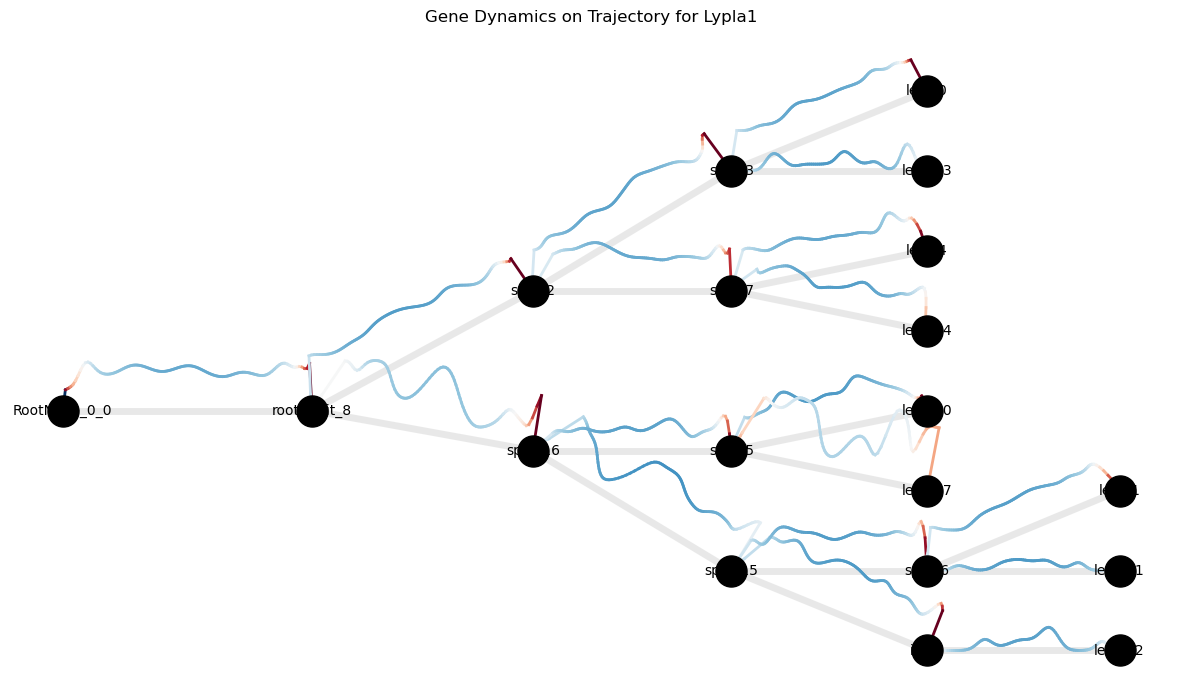

In [19]:
plot_gene_dynamics_on_trajectory(traj_graph, beta_assignments, adata, gene_name='Lypla1',
                                 resolution=100, curve_scale=100.0, blend_fraction=0.1,
                                 title="Gene Dynamics on Trajectory for Lypla1")